In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn, Tensor
import torch.nn.functional as F
import pandas as pd

import vit
import vit1
from helper import *

In [2]:
if torch.cuda.is_available() and USE_CUDA == True:
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [22]:
DATASET = 0

# USE 0 for combined dataset, use 1 for anm1, use 2 for anm2, and 3 for adni

In [23]:
nets = ["combined", "anm1", "anm2", "adni"]
datasets = ["", "1", "2", "_adni"]

In [24]:
train = geneDataset(f"train{datasets[DATASET]}")
test = geneDataset(f"test{datasets[DATASET]}")

In [25]:
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

In [26]:
net = torch.load(f"nets/{nets[DATASET]}.pt")
net.to(device)

VisionTransformer(
  (embedding_layer): EmbeddingStem(
    (pos_drop): Dropout(p=0.0, inplace=False)
    (projection): Sequential(
      (0): Conv2d(1, 96, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (qkv): Linear(in_features=96, out_features=288, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Conv1d(96, 192, kernel_size=(1,), stride=(1,))
            (1): BatchNorm1d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): GELU(approximate=none)
            (3): Dropout(p=0.0, inplace=False)
            (4): Conv

In [27]:
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

624385


In [28]:
pos = 0
neg = 0

wrong = 0
right = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data

        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = torch.clamp(net(X), min=0.0, max=1.0)

        for i in range(len(output)):
            if y[i][0] == round(float(output[i][0])):
                right += 1
            else:
                wrong += 1

            total += 1

print(right / total)

0.8842105263157894


In [29]:
RES = 1000

In [30]:
falsePos = [0] * RES
truePos = [0] * RES
falseNeg = [0] * RES
trueNeg = [0] * RES

In [31]:
from tqdm.notebook import tqdm

with torch.no_grad():
    for data in tqdm(testset):
        X, y = data
        
        X = X.to(device)
        y = y.to(device)
        
        net.eval()

        output = net(X)
        
        for i in range(RES):
            loss = wrongAns(output, y, 2 * i / (RES - 1) - 0.5)
            truePos[i] += loss[0]
            falsePos[i] += loss[1]
            trueNeg[i] += loss[2]
            falseNeg[i] += loss[3]

  0%|          | 0/19 [00:00<?, ?it/s]

Accuracy: 0.9
729


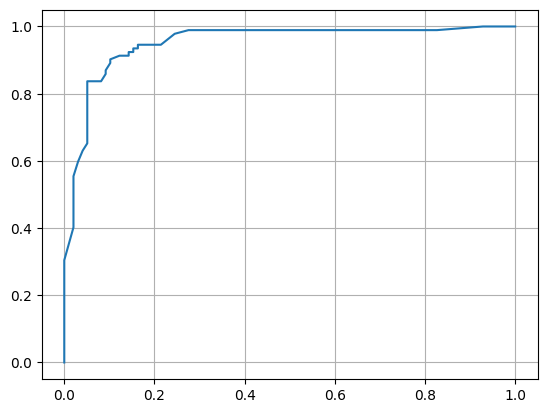

In [32]:
hAcu = 0

falsePosRate = []
truePosRate = []

for i in range(len(truePos)):
    falsePosRate.append(falsePos[i] / (falsePos[i] + trueNeg[i]))
    truePosRate.append(truePos[i] / (truePos[i] + falseNeg[i]))

for i in range(RES):
    if hAcu < truePos[i] + trueNeg[i]:
        hAcu = truePos[i] + trueNeg[i]
        lowestIndex = i

print(f"Accuracy: {(truePos[lowestIndex] + trueNeg[lowestIndex]) / (falsePos[0] + falseNeg[0] + truePos[0] + trueNeg[0])}")
print(lowestIndex)
    
plt.plot(falsePosRate, truePosRate)
plt.grid()

In [33]:
import sklearn.metrics

auc = sklearn.metrics.auc(falsePosRate, truePosRate)

print(auc)

0.9510314995563443


In [34]:
data = iter(testset)

tensor([1.], device='cuda:0')


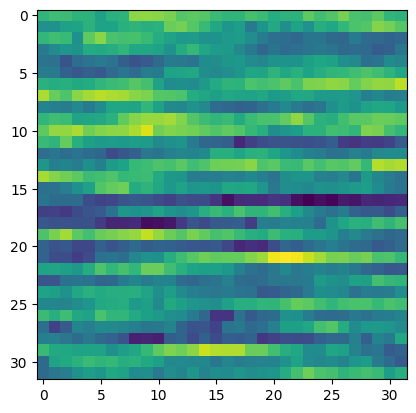

In [35]:
X, y = data.next()

X = X.to(device)
y = y.to(device)
        
output = net(X)

print(y[0])
plt.imshow(X[0].view((32, 32)).cpu())

In [36]:
i = 0

tensor([1.], device='cuda:0')
tensor([1.0125], device='cuda:0', grad_fn=<SelectBackward0>)


1

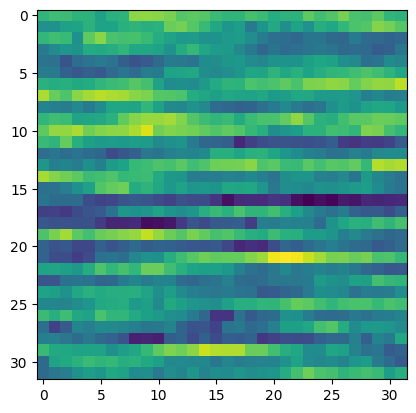

In [37]:
print(y[i])
print(output[i])
plt.imshow(X[i].view((32, 32)).cpu())

i += 1
i %= 100

i

In [38]:
print(y.view(-1))

tensor([1., 1., 1., 0., 0., 1., 1., 1., 0., 0.], device='cuda:0')


In [39]:
print(output.view(-1))


tensor([ 1.0125,  0.9842,  1.0082, -0.0422,  0.3213,  0.9899,  0.9946,  0.9872,
        -0.0386, -0.0452], device='cuda:0', grad_fn=<ViewBackward0>)


In [40]:
print(X)

tensor([[[[1.3403, 1.3646, 1.3590,  ..., 1.4001, 1.3419, 1.3344],
          [1.2447, 1.2482, 1.2877,  ..., 1.4408, 1.4257, 1.3926],
          [1.3430, 1.3648, 1.3517,  ..., 1.1410, 1.1264, 1.1362],
          ...,
          [1.3529, 1.3078, 1.3044,  ..., 1.1728, 1.1040, 1.1254],
          [1.1406, 1.2882, 1.3102,  ..., 1.1826, 1.1432, 1.1007],
          [1.1409, 1.1740, 1.1930,  ..., 1.3533, 1.2764, 1.3194]]],


        [[[1.0333, 0.9897, 1.0301,  ..., 1.0867, 1.1025, 1.0920],
          [1.1210, 1.0644, 1.0604,  ..., 1.0167, 1.0173, 1.0245],
          [1.0741, 1.0983, 0.9599,  ..., 1.0534, 1.0688, 1.0736],
          ...,
          [1.1151, 1.1427, 1.1238,  ..., 0.9783, 0.9307, 0.8525],
          [0.8911, 0.9057, 0.8859,  ..., 1.0315, 1.0151, 1.0076],
          [1.0148, 1.0120, 0.9326,  ..., 0.9519, 0.9730, 0.9525]]],


        [[[1.2241, 1.2017, 1.1394,  ..., 1.0900, 1.0689, 1.0556],
          [1.0629, 1.0394, 1.0687,  ..., 1.2162, 1.1408, 1.1206],
          [1.1881, 1.2040, 1.1523,  ..